In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import tqdm
import ffmpeg
from scipy.ndimage.filters import gaussian_filter1d

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
### Load behavior 

### standard ###
#file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/20221202_master_X_noYclip.npy"

### ACCEL ###
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/master_X_acceleration.npy"

X_beh = np.load(file)
X_beh.shape

# pos/neg refers to velocity, plus/minus refers to acceleration
# behaviors = ['Y_pos_plus', 'Y_pos_minus',
#              'Z_pos_plus', 'Z_pos_minus',
#              'Z_neg_plus', 'Z_neg_minus']

(49, 9, 3000, 3384)

In [5]:
# the main thing to deal with now is the z-depth
# for a given supercluster, i need to know the original median z-depth for each fly
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


In [6]:
superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

(256, 128, 49)

In [7]:
original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:23<00:00,  2.61s/it]


In [8]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], bins_x, bins_y

In [22]:
cluster_ = 77

all_2d_hists = []
for cluster in [cluster_,cluster_+250]:
    Xs_new = []
    for fly in range(9):
        Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
    Xs_new = np.asarray(Xs_new)
    beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

    for j,shift in tqdm.tqdm(enumerate(np.arange(-200,200,1))):
        Y_var = beh_cluster[1250+shift,:]+beh_cluster[1750+shift,:]*-1 # left turn accel
        Y_var /= np.std(Y_var)

        X_var = beh_cluster[250+shift,:]+beh_cluster[750+shift,:]*-1 # forward accel
        X_var /= np.std(X_var)

        start_x=-6; end_x=6; start_y=-5; end_y=5 # ADJUST

        signal = supercluster_signals[cluster,:]
        fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                         num_bins_x=25, num_bins_y=25,
                                         start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                         min_num_samples=9)

        #fictrac_2d[-1,:] = 0
        all_2d_hists.append(fictrac_2d)
all_2d_hists = np.asarray(all_2d_hists)
all_2d_hists = np.reshape(all_2d_hists,(2,400,25,25))
print(all_2d_hists.shape)

400it [00:20, 19.40it/s]
400it [00:20, 19.37it/s]

(2, 400, 25, 25)


In [23]:
all_2d_hists = all_2d_hists[:,::-1,:,:] ### FLIP TIME TO BE "FORWARD"
all_2d_hists_smooth = gaussian_filter1d(all_2d_hists,sigma=3,axis=1)

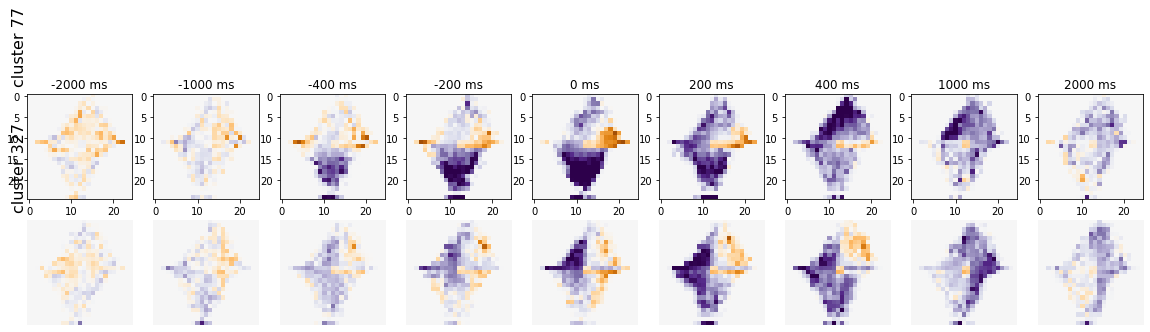

In [27]:
plt.figure(figsize=(20,10))
vmax = np.max(all_2d_hists_smooth)/2
tps = [100,150,180,190,200,210,220,250,300]

for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1)
    plt.title(F"{(tp-200)*20} ms")
    plt.imshow(all_2d_hists_smooth[0,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax)#,extent=[-2.35,6,-4.35,4])
    #plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=16)
    
for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1+len(tps))
    plt.imshow(all_2d_hists_smooth[1,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax)#,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_+250}",rotation=90,fontsize=16)
    
plt.subplots_adjust(hspace=-.7)

# loop version

In [ ]:
for cluster_ in tqdm.tqdm(range(251)):
    all_2d_hists = []
    for cluster in [cluster_,cluster_+250]:
        Xs_new = []
        for fly in range(9):
            Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
        Xs_new = np.asarray(Xs_new)
        beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

        for j,shift in enumerate(np.arange(-200,200,1)):
            Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
            Y_var /= np.std(Y_var)

            X_var = beh_cluster[250+shift,:]
            X_var /= np.std(X_var)

            start_x=-2; end_x=6; start_y=-4; end_y=4

            signal = supercluster_signals[cluster,:]
            fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                             num_bins_x=25, num_bins_y=25,
                                             start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                             min_num_samples=9)

            fictrac_2d[-1,:] = 0
            all_2d_hists.append(fictrac_2d)
    all_2d_hists = np.asarray(all_2d_hists)
    all_2d_hists = np.reshape(all_2d_hists,(2,400,25,25))

    all_2d_hists = all_2d_hists[:,::-1,:,:] ### FLIP TIME TO BE "FORWARD"
    all_2d_hists_smooth = gaussian_filter1d(all_2d_hists,sigma=3,axis=1)

    plt.figure(figsize=(20,10))
    vmax = np.max(all_2d_hists_smooth)/2
    tps = [100,150,180,190,200,210,220,250,300]

    for j,tp in enumerate(tps):
        plt.subplot(2,len(tps),j+1)
        plt.title(F"{(tp-200)*20} ms")
        plt.imshow(all_2d_hists_smooth[0,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
        plt.axis('off')
        if j==0:
            plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=16)

    for j,tp in enumerate(tps):
        plt.subplot(2,len(tps),j+1+len(tps))
        plt.imshow(all_2d_hists_smooth[1,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
        plt.axis('off')
        if j==0:
            plt.text(-4,-3,F"cluster {cluster_+250}",rotation=90,fontsize=16)

    plt.subplots_adjust(hspace=-.7)
    
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20221203_temporal_2d_hists'
    #timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{cluster_}')
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.clf()
    plt.cla()

 71%|███████   | 178/251 [2:11:10<54:01, 44.41s/it]  

In [20]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20221202_2dhist_movies/116'
os.mkdir(save_path)

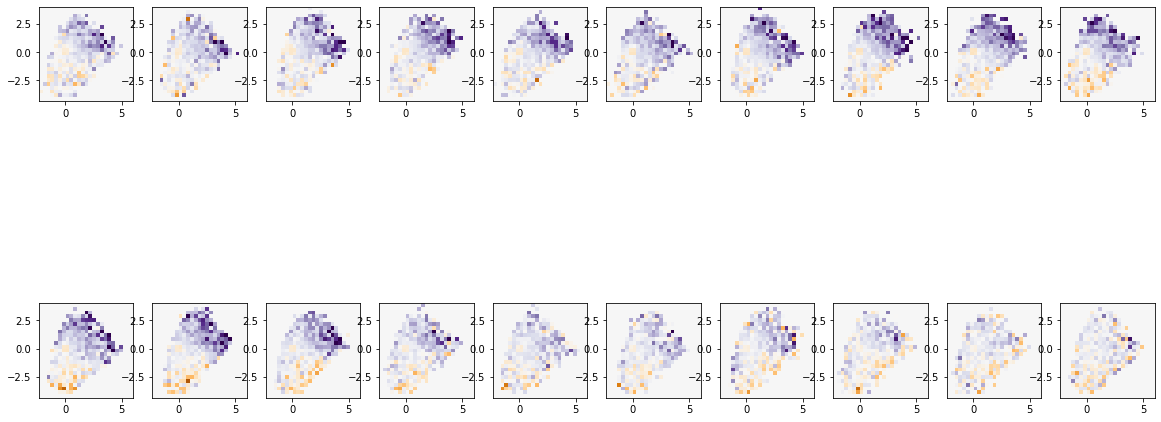

In [15]:
cluster = 116
Xs_new = []
for fly in range(9):
    Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
Xs_new = np.asarray(Xs_new)
beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

plt.figure(figsize=(20,10))

for j,shift in enumerate(np.arange(-60,60,6)):
    Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
    Y_var /= np.std(Y_var)

    X_var = beh_cluster[250+shift,:]
    X_var /= np.std(X_var)

    start_x=-2; end_x=6; start_y=-4; end_y=4

    signal = supercluster_signals[cluster,:]
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    vmax = .1#np.percentile(np.abs(fictrac_2d),98)
    
    plt.subplot(2,10,j+1)
    plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])

# ACCEL

In [41]:
Xs_new = []

In [64]:
cluster = 150

Xs_new = []
for fly in range(9):
    Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
Xs_new = np.asarray(Xs_new)
beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))
beh_cluster.shape

(3000, 30456)

In [65]:

# pos/neg refers to velocity, plus/minus refers to acceleration
# behaviors = ['Y_pos_plus', 'Y_pos_minus',
#              'Z_pos_plus', 'Z_pos_minus',
#              'Z_neg_plus', 'Z_neg_minus']
cluster

150

In [92]:
shift=-50

Y_var = beh_cluster[1250+shift,:]+beh_cluster[1750+shift,:]*-1 # left turn accel
Y_var /= np.std(Y_var)

X_var = beh_cluster[250+shift,:]+beh_cluster[750+shift,:]*-1 # forward accel
X_var /= np.std(X_var)

start_x=-6; end_x=6; start_y=-5; end_y=5

signal = supercluster_signals[cluster,:]
fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

#fictrac_2d[-1,:] = 0


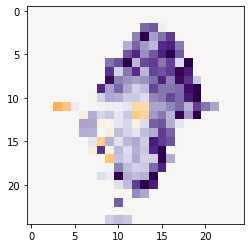

In [93]:
vmax = np.max(fictrac_2d)/1.5
plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax)
# at t=0, this is decel

In [50]:
shift=0
Y_var = beh_cluster[1250,:]+beh_cluster[1750,:]*-1 # left turn accel
Y_var /= np.std(Y_var)

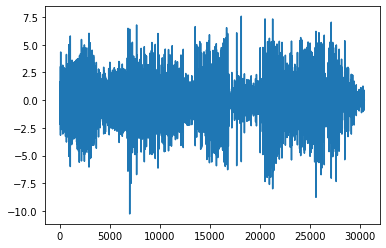

In [52]:
plt.plot(Y_var)